In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.datasets as datasets
import torch.nn as nn

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),                               
     transforms.Normalize(mean=(0.1307,), std=(0.3081,))  
    ])
#temp transform for datasets load

In [3]:
mnist_train = datasets.MNIST(root='./data/', train=True,
transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data/', train=False,
transform=transform, download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
fashion_train = datasets.FashionMNIST('./data/', download=True, train=True, transform=transform)
fashion_test = datasets.FashionMNIST('./data/', download=True, train=False, transform=transform)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [5]:
!rm -rf test
!rm -rf train

!mkdir test
!mkdir train
#create dirs.

In [6]:
import os

num_classes = 20
number_per_class = {}
#counter for img name of each class.
def setzero():
  for i in range(num_classes):
      number_per_class[i] = 0
setzero()

In [7]:
def imsaver(imgtype, img, label): 
  if number_per_class[label] >= 2000:
    return
  path = imgtype + '/' + str(label) + '/' 
  if not os.path.exists(path): 
    os.makedirs(path)


  save_image(img, path + str(number_per_class[label]) + '.jpg')
  #print('train/' + str(label) + '/' +  str(number_per_class[label]) + '.jpg' + ' saved..')
  number_per_class[label] += 1

#function for save image in to class folder.


In [8]:
for idx, (img, _) in enumerate(mnist_train):
    imsaver('train',img,int(mnist_train.targets[idx]))

In [9]:
setzero()
for idx, (img, _) in enumerate(mnist_test):
    imsaver('test',img,int(mnist_test.targets[idx]))

In [10]:
fashion_train.targets = fashion_train.targets + 10
fashion_test.targets = fashion_test.targets + 10


In [11]:

setzero()
for idx, (img, _) in enumerate(fashion_train):
    imsaver('train',img,int(fashion_train.targets[idx]))
setzero()
for idx, (img, _) in enumerate(fashion_test):
    imsaver('test',img,int(fashion_test.targets[idx]))

In [13]:
#Custom Dataset which load image folder into dataset.

#folder names = class name, files under the folder belong to it.
class CustomDataset(Dataset):

    def __init__(
            self,
            root,
            transform = None,):  
        self.root = root
        classes, class_to_idx = self._find_classes(self.root)
        samples = self._make_dataset(self.root, class_to_idx)
        self.samples = samples
        self.transform = transform
     
        
        
    def _make_dataset(self,directory, class_to_idx):
      instances = []
      directory = os.path.expanduser(directory)
      for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)         
                item = path, class_index
                instances.append(item)
      return instances

    def _find_classes(self, dir):

        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx


    def __getitem__(self, index):

        path, target = self.samples[index]
        sample = self._img_loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        return sample, target

    def __len__(self):
        return len(self.samples)

    def _img_loader(self,path):
        with open(path, 'rb') as f:
          img = Image.open(f)
          return img.convert('L')

In [39]:
data_transform = transforms.Compose([
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
     ])
traindataset = CustomDataset('./train',data_transform)

In [40]:
testdataset = CustomDataset('./test',data_transform)

In [41]:
 dataset_loader = torch.utils.data.DataLoader(traindataset,
                                              batch_size=100, shuffle=True,
                                              num_workers=4)

In [42]:
testdataset_loader = torch.utils.data.DataLoader(testdataset,
                                              batch_size=100, shuffle=True,
                                              num_workers=4)

In [74]:
MODEL_NAME = 'CNN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

MODEL_NAME = CNN, DEVICE = cuda


CNN MODEL.

기본적으로 모델은 CNN의 convolution - BatchNorm - ReLU - Pooling - Fullyconnected layers 구조를 갖는다. Convolution은 기본적으로 3 kernel size에 1padding을 적용시켰다.

Convolution을 진행하며 채널의 크기를 늘리고 pooling을 통해 width,height를 줄여 계산량을 감소시켰다. Dataloader에서 normaliztion을 하는 대신,  Conv - ReLU 사이에 BatchNormalization을 수행하여 Gradient vanishing, exploding을 방지하였다.

3번의 Convolution layer를 통과시킨 후,

그 후 Fully connected layer를 통과시키며 채널수를 output개수에 맞춰가고, dropout방식을 이용해 안정성을 더하였다.


Cuda사용,3분, 정확도최고 93%



In [85]:
class CustomCNN(nn.Module):
    """
        Simple CNN Clssifier
    """
    def __init__(self, num_classes=20):
        super(CustomCNN, self).__init__()
        
        self.conv = nn.Sequential(
            # MINST DATA -> (N, 1, 28, 28) N = batch size, ch, height, width
            nn.Conv2d(1, 96, kernel_size=3, stride=1, padding=1),  #shape(N,96,28,28)
            nn.BatchNorm2d(96),
            nn.ReLU(),

            nn.MaxPool2d(2, 2), # (N,96,14,14)

            nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1),  #N, 192, 14 14
            nn.BatchNorm2d(192),
            nn.ReLU(),

            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),  #N, 192, 14 14
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # (N,192,7,7)

            
        ) 

        self.fc = nn.Sequential( #fully connected 영역 묶어줌
            nn.Linear(7*7*192, 512), #output 512, 
            nn.Linear(512, 128),
            nn.Dropout(p=0.3), 
            nn.Linear(128, num_classes),
  
        ) 
        
    def forward(self, x):
        y_ = self.conv(x) 
        y_ = y_.view(y_.size(0), -1) 
        y_ = self.fc(y_)
        return y_

In [86]:
model = CustomCNN().to(DEVICE)

In [87]:
# utility function to measure time
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [88]:

criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses = []

In [89]:
max_epoch = 10     
step = 0           

plot_every = 400
total_loss = 0 

start = time.time()

for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(dataset_loader):
       
        x, y = images.to(DEVICE), labels.to(DEVICE) 
        
        y_hat = model(x)
       
        loss = criterion(y_hat, y) 
        total_loss += loss.item()
          
        optim.zero_grad()          
        loss.backward()            
        optim.step()               
        
       
        if step % 500 == 0:
            print('Epoch({}): {}/{}, Step: {}, Loss: {}'.format(timeSince(start), epoch, max_epoch, step, loss.item()))
        
        if (step + 1) % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
        
       
        if step % 1000 == 0:
            model.eval()
            acc = 0.
            with torch.no_grad():  
                for idx, (images, labels) in enumerate(testdataset_loader):
                    x, y = images.to(DEVICE), labels.to(DEVICE) 
                    y_hat = model(x) 
                    loss = criterion(y_hat, y)
                    _, indices = torch.max(y_hat, dim=-1)    
                                                              
                    acc += torch.sum(indices == y).item()    
                                                             
            print('*'*20, 'Test', '*'*20)
            print('Step: {}, Loss: {}, Accuracy: {} %'.format(step, loss.item(), (acc/len(testdataset))*100))
            print('*'*46)
            model.train()         
        step += 1

Epoch(0m 0s): 0/10, Step: 0, Loss: 3.005599021911621
******************** Test ********************
Step: 0, Loss: 2.9784209728240967, Accuracy: 13.91 %
**********************************************
Epoch(0m 31s): 1/10, Step: 500, Loss: 0.2779008448123932
Epoch(0m 54s): 2/10, Step: 1000, Loss: 0.443180650472641
******************** Test ********************
Step: 1000, Loss: 0.36894309520721436, Accuracy: 90.715 %
**********************************************
Epoch(1m 25s): 3/10, Step: 1500, Loss: 0.2628761827945709
Epoch(1m 49s): 5/10, Step: 2000, Loss: 0.1636897623538971
******************** Test ********************
Step: 2000, Loss: 0.1832960546016693, Accuracy: 90.635 %
**********************************************
Epoch(2m 19s): 6/10, Step: 2500, Loss: 0.07757361978292465
Epoch(2m 43s): 7/10, Step: 3000, Loss: 0.18554610013961792
******************** Test ********************
Step: 3000, Loss: 0.4237290620803833, Accuracy: 92.19000000000001 %
**********************************

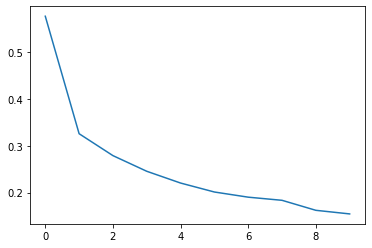

In [90]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)